<a href="https://colab.research.google.com/github/LuanPCunha/TCC/blob/main/model_concat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# instalar apenas um vez
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.5 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3143776 sha256=b647cb976c8c26f493bb8980789f92fa44e1e6fec0b241c116c060d04a12ec88
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
# Downloading fasttext word vectors
# https://fasttext.cc/docs/en/crawl-vectors.html
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.pt.300.vec.gz
! gunzip cc.pt.300.vec.gz



--2022-05-23 23:01:15--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.pt.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1271093660 (1.2G) [binary/octet-stream]
Saving to: ‘cc.pt.300.vec.gz’

cc.pt.300.vec.gz    100%[===================>]   1.18G  29.5MB/s    in 37s     

2022-05-23 23:01:53 (33.1 MB/s) - ‘cc.pt.300.vec.gz’ saved [1271093660/1271093660]



In [ ]:
!pip install pyvi
!pip install emoji
from numpy.random import seed
import gensim 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 5.4 MB/s 
     |████████████████████████████████| 965 kB 46.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 4.9 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=bd5bf8efc59137ae39237f2dfb550765fb530cb5e89e327cb95e47bd09f4f6ef
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [ ]:
import time
start_time = time.time()
from sklearn.model_selection import train_test_split
import sys, os, re, csv, codecs, numpy as np, pandas as pd
np.random.seed(32)
os.environ["OMP_NUM_THREADS"] = "4"
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
#from keras.engine import InputSpec, Layer
from tensorflow.keras.layers import InputSpec
import logging
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

## Li que a acurácia não é um bom avaliador de desempenho para bases desbalanceadas por isso usa curva ROC

In [ ]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

## Tem que alterar os nomes da varáveis para não ter que fazer isso em todo o programa, fiz isso no nosso arquivo csv no notepad mesmo


*   label será label_id
*   text será free_text



In [ ]:
# lendo arquivo da base a ser classificada
dataText = pd.read_csv('/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_classificada_balanceada.csv')


In [ ]:
#verificando quantas colunas a base tem
# tem uma coluna a mais
dataText.shape

(10574, 3)

In [ ]:
# vertificando o nome da coluna para dropar
print(dataText.columns.tolist())

['Unnamed: 0', 'text', 'label']


In [ ]:
dataText.rename(columns = {'text':'free_text', 'label':'label_id'}, inplace = True)

In [ ]:
dataText = dataText.drop(['id'], axis =1)

KeyError: ignored

In [ ]:
dataText.shape

(10574, 3)

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split
# separando a base
# test_size = 20% para redes  DL é o permitido
# random_starte = 42


train_x, valid_x, train_y, valid_y = model_selection.train_test_split(dataText['free_text'], dataText['label_id'], test_size = 0.20, random_state=42)

## Código original onde se lê os arquivos mas foi feito em tempo de execução a divisão

In [ ]:


# dataTrainText= train_x
# pd.DataFrame(dataTrainText).to_csv("/content/drive/MyDrive/Colab Notebooks/BASES/concat/dataTrainText.csv",index=False)


# dataTrainLabel= train_y
# pd.DataFrame(dataTrainLabel).to_csv("/content/drive/MyDrive/Colab Notebooks/BASES/concat/dataTrainLabel.csv",index=False)

# dataTestText= valid_x
# pd.DataFrame(dataTestText).to_csv("/content/drive/MyDrive/Colab Notebooks/BASES/concat/dataTestText.csv",index=False)

# dataTestLabel = valid_y
# pd.DataFrame(dataTestLabel).to_csv("/content/drive/MyDrive/Colab Notebooks/BASES/concat/dataTestLabel.csv",index=False)


## contando a quantidade de palavras unicas

### não precisava fazer

In [ ]:
#Número de palavras únicas em cada linha
# é o valor do max_features

palavras_unicas = list(dataText['free_text'].str.split(' ', expand=True).stack().unique())
len(palavras_unicas)

19043

In [ ]:
# Apos extrair os embeddings chamar no raiz ou pode salvar depois no drive para não ter que fazer download sempre
embedding_path = "/content/cc.pt.300.vec"

#tamanho do wordvector fasttext
embed_size = 300

#palavras unicas apesar de terem 9144 na base deu erro ao inserir este valor no trienamento
max_features = 5000

# máximo numero de palavras  nos tweets
max_len = 150

## Apenas alterei para ter os nomes das varáveis que o programa usa

In [ ]:
#train_x, valid_x, train_y, valid_y
train_descs = train_x


y_train = train_y
 
test_descs = valid_x

y_test = valid_y

test_text=dataText['free_text']

## Não precisa rodar essa rotina mas eu rodei !!!

### não faz diferença

In [ ]:
#preprocessing data
import re 
import emoji
def Preprocess(string):
#Remove extended characters Ex:đẹppppppp
    string = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), string, flags=re.IGNORECASE)
#Remove special characters
    string = gensim.utils.simple_preprocess(string)
    string = ' '.join(string)
    string = re.sub(r"[-()\\\"#/@;:<>{}`+=~|.!?,%/]", "",string)
    string = re.sub('\n', ' ',string)
    string = re.sub('--', '',string)
    string = re.sub('  ', ' ',string)
    string = re.sub('   ', ' ',string)
    string = re.sub('    ', ' ',string)
#lowercase
    string = string.lower()
#Remove link
    string = re.sub('<.*?>', '', string).strip()
    string = re.sub('(\s)+', r'\1', string)
#Remove number
    string = re.sub(r"\d+", "", string)
#Remove useless English phrases
    string = re.sub("added.*photo", "", string)
    string = re.sub("added.*photos", "", string)
    string = re.sub("is.*post", "", string)
    string = re.sub("Photos.*post", "", string)
    string = re.sub("from.*post", "", string)
    string = re.sub("shared.*group", "", string)
    string = re.sub("shared.*post", "", string)
    string = re.sub("shared.*video", "", string)
    string = re.sub("is.*motivated", "", string)
    string = re.sub("is.*with", "", string)
    
#Remove redundant characters
    string = string.replace(u'"', u' ')
    string = string.replace(u'️', u'')
    string = string.replace('🏻','')
    string = string.replace('_',' ')
    string = string.replace('—',' ')
    string = " ".join(string.split())
    string = string.replace('url','')
    return string

for i in range(len(train_descs)): 
    train_descs.values[i]=Preprocess(train_descs.values[i])
    
for i in range(len(test_descs)): 
    test_descs.values[i]=Preprocess(test_descs.values[i])   

for i in range(len(test_text)): 
    test_text.values[i]=Preprocess(test_text.values[i])    
    
#Remove emoji  
def give_emoji_free_text(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])

    return clean_text

for i in range(len(train_descs)):
    train_descs.values[i]=give_emoji_free_text(train_descs.values[i])
    
for i in range(len(test_descs)): 
    test_descs.values[i]=give_emoji_free_text(test_descs.values[i])   

for i in range(len(test_text)): 
    test_text.values[i]=give_emoji_free_text(test_text.values[i])    
    

In [ ]:
## aceertar isso , porque é para vietnamita


from pyvi import ViTokenizer, ViPosTagger 
from tqdm import tqdm
import numpy as np

def word_segment(string):
    string=ViTokenizer.tokenize(string)
    return string
                                  
for i in range(len(train_descs)): 
    train_descs.values[i]=word_segment(train_descs.values[i])
    
for i in range(len(test_descs)): 
    test_descs.values[i]=word_segment(test_descs.values[i])   

for i in range(len(test_text)): 
    test_text.values[i]=word_segment(test_text.values[i]) 

In [ ]:
tk = Tokenizer(num_words = max_features, lower = True)

tk.fit_on_texts(train_descs)

x_train = tk.texts_to_sequences(train_descs)

x_test = tk.texts_to_sequences(test_descs)

x_test_text = tk.texts_to_sequences(test_text)

In [ ]:

from sklearn.preprocessing import LabelBinarizer
x_train = pad_sequences(x_train, maxlen = max_len)
x_test = pad_sequences(x_test, maxlen = max_len)
x_test_text= pad_sequences(x_test_text, maxlen = max_len)

encoder = LabelBinarizer()
encoder.fit(y_train)
Y_train = encoder.transform(y_train)
Y_test = encoder.transform(y_test)

In [ ]:
len(Y_train)

8459

In [ ]:
len(Y_test)

2115

## Essa função get_coefs demora um pouco

In [ ]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))

word_index = tk.word_index
#nb_words = min(max_features, len(word_index)+1)
nb_words = max_features
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:

from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import GRU, BatchNormalization, Conv1D, MaxPooling1D

#Retirei aqui está apenas checando o modelo criado e salvando
#file_path = "/content/best_model.hdf5"
#check_point = ModelCheckpoint(monitor = "val_loss", verbose = 1,save_best_only = True, mode = "min")


ra_val = RocAucEvaluation(validation_data=(x_test, Y_test), interval = 1)
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)

In [ ]:
from keras.callbacks import CSVLogger
def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
    inp = Input(shape = (max_len,))
    #x = Embedding(len(word_index)+1, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x = Embedding(5000, embed_size, weights = [embedding_matrix], trainable = False)(inp) 

    x1 = SpatialDropout1D(dr)(x)

    x = Bidirectional(GRU(units, return_sequences = True))(x1)
    x = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    
    y = Bidirectional(LSTM(units, return_sequences = True))(x1)
    y = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(y)
    
    avg_pool1 = GlobalAveragePooling1D()(x)
    max_pool1 = GlobalMaxPooling1D()(x)
    
    avg_pool2 = GlobalAveragePooling1D()(y)
    max_pool2 = GlobalMaxPooling1D()(y)
    
    
    x = concatenate([avg_pool1, max_pool1, avg_pool2, max_pool2])

    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    csv_logger = CSVLogger('log.csv', append=True, separator=';')
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ['accuracy'])
    history = model.fit(x_train, Y_train, batch_size = 128, epochs = 10, validation_data = (x_test, Y_test), 
                        verbose = 1, callbacks = [ra_val,early_stop,csv_logger])
     #model = load_model(file_path)
    history_dict = history.history
    print(history.history.keys())
  
    return model
  

In [ ]:
from numpy.random import seed  
#from tensorflow import set_random_seed
import tensorflow as tf
tf.random.set_seed(1)
tf.random.set_seed(2)

#seed(1)
#set_random_seed(1)
model = build_model(lr = 1e-3, lr_d = 0, units = 32, dr = 0.5)

#seed(2)
#set_random_seed(2)
pred = model.predict(x_test_text, batch_size = 1024, verbose = 1)





Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


66/67 [============================>.] - ETA: 0s - loss: 0.6031 - accuracy: 0.7015
 ROC-AUC - epoch: 1 - score: 0.904645
67/67 [==============================] - 13s 96ms/step - loss: 0.6029 - accuracy: 0.7015 - val_loss: 0.4494 - val_accuracy: 0.7887
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 0.4383 - accuracy: 0.8012
 ROC-AUC - epoch: 2 - score: 0.932337
67/67 [==============================] - 4s 53ms/step - loss: 0.4383 - accuracy: 0.8012 - val_loss: 0.3616 - val_accuracy: 0.8567
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 0.3844 - accuracy: 0.8350
 ROC-AUC - epoch: 3 - score: 0.949673
67/67 [==============================] - 3s 52ms/step - loss: 0.3844 - accuracy: 0.8350 - val_loss: 0.3148 - val_accuracy: 0.8799
Epoch 4/10
67/67 [==============================] - ETA: 0s - loss: 0.3430 - accuracy: 0.8570
 ROC-AUC - epoch: 4 - score: 0.959988
67/67 [==============================] - 3s 52ms/step - loss: 0.3430 - accuracy: 0.8570 - va

In [ ]:
print("[{}] Completed!".format(time.time() - start_time))

[1287.6652703285217] Completed!


In [ ]:
score = model.evaluate(x_test, Y_test, batch_size = 128, verbose = True)
 
print('\nTest val_loss:', score[0])
print('Categorical accuracy:', score[1])


17/17 [==============================] - 0s 18ms/step - loss: 0.2193 - accuracy: 0.9225

Test val_loss: 0.21927669644355774
Categorical accuracy: 0.9224586486816406


In [ ]:
y_prob = model.predict(x_test) 
y_labelpred = y_prob.argmax(axis=-1)
#len(y_prob)
len(y_labelpred)
#for i in y_labelpred:
 #    print(i)

2115

In [ ]:
import pandas as pd
his = pd.read_csv('log.csv',sep=';') 
his.head(10)

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.701501,0.602871,0.788652,0.449410
1,1,0.801159,0.438303,0.856738,0.361634
2,2,0.834969,0.384366,0.879905,0.314778
3,3,0.856957,0.342988,0.897872,0.271322
4,4,0.867124,0.325280,0.914894,0.244858
5,5,0.875163,0.312253,0.917731,0.235046
6,6,0.880009,0.300425,0.919622,0.231948
7,7,0.879537,0.294440,0.920095,0.228800
8,8,0.885920,0.288617,0.922459,0.221757
9,9,0.889349,0.276924,0.922459,0.219277


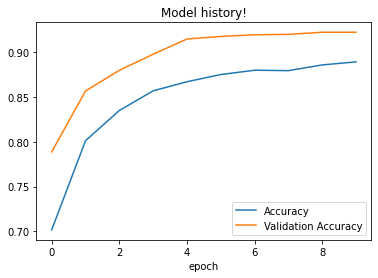

In [ ]:
import matplotlib.pyplot as plt

# line 1 points
x1 = his['epoch']
y1= his['accuracy']
# plotting the line 1 points
plt.plot(x1, y1, label = "Accuracy")

# line 2 points
y2 = his['val_accuracy']
# plotting the line 2 points
plt.plot(x1, y2, label = "Validation Accuracy")

# naming the x axis
plt.xlabel('epoch')
# naming the y axis
# plt.ylabel('accuracy')
# giving a title to my graph
plt.title('Model history!')

# show a legend on the plot
plt.legend()

# function to show the plot
plt.show()


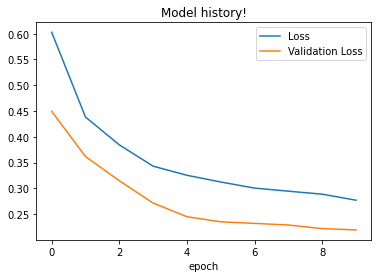

In [ ]:
import matplotlib.pyplot as plt

# line 1 points
x1 = his['epoch']
y3= his['loss']
# plotting the line 1 points
plt.plot(x1, y3, label = "Loss")

# line 2 points
y4 = his['val_loss']
# plotting the line 2 points
plt.plot(x1, y4, label = "Validation Loss")

# naming the x axis
plt.xlabel('epoch')
# naming the y axis
# plt.ylabel('accuracy')
# giving a title to my graph
plt.title('Model history!')

# show a legend on the plot
plt.legend()

# function to show the plot
plt.show()


In [ ]:
y_labeltrue=Y_test
len(y_labeltrue)
#for i in y_labeltrue:
#     print(i)

2115

In [ ]:
y_test_text = model.predict(x_test_text) 

testText = pred



In [ ]:
len(y_test_text)

10574

In [ ]:
from sklearn.metrics import f1_score, precision_recall_fscore_support as score
print('macro_F1: ',f1_score(y_labeltrue,y_labelpred, average='macro'))
print('micro_F1: ',f1_score(y_labeltrue,y_labelpred, average='micro'))

macro_F1:  0.33111954459203036
micro_F1:  0.4950354609929078


In [ ]:
from sklearn.metrics import hamming_loss
hamming_loss(y_labeltrue,y_labelpred)

0.5049645390070922

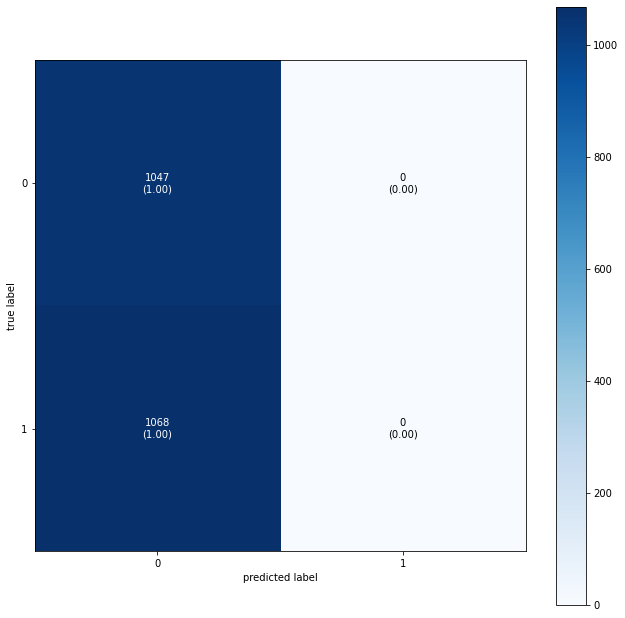

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

target_names = ['0', '1']

classes = confusion_matrix(y_labeltrue,y_labelpred)

fig,ax = plot_confusion_matrix(figsize=(11, 11),conf_mat=classes,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
#                                 class_names=target_names,
                              )
plt.show()

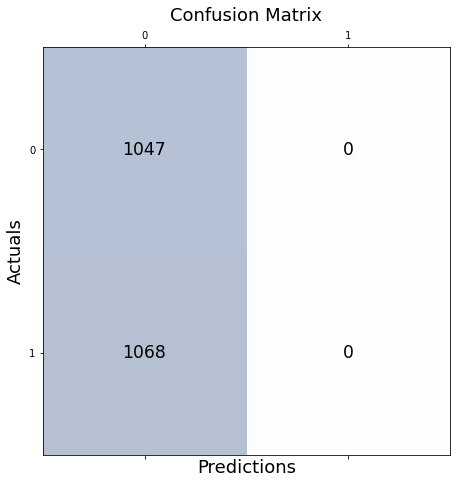

In [ ]:
# Get the predictions
#

#
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_labeltrue,y_labelpred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()